In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter
import pickle
from scipy.signal import convolve
import matplotlib.image as image
import sys
import matplotlib.colors as colors
import matplotlib.cm as cmx
import os
from scipy.fft import fft, fftfreq
from scipy.signal import  find_peaks
from scipy.optimize import curve_fit

# Impulse response of FB network and how it changes with w and tau (from Jenny's paper)

In [2]:

home = os.path.expanduser("~")


sys.path.insert(1, f'{home}/Documents/Repositories/motion_anticipation_network/model')
from utils import  DOG


In [3]:
#make impulse stimulus
def impulse_stimulus(length = 1.,impulse_timepoint = 0, amplitude = 1, dt = 0.001):


    tps = int(length/dt)
    barstim = np.zeros(tps)


    impulse_idx = int(impulse_timepoint/dt)
    barstim[impulse_idx] = amplitude

    #timeline = np.arange(0,length,self.dt)

    return barstim


def step_stimulus(length = 5.,start = 1.0, stop = 3.0, amplitude = 1, dt = 0.001):



    stimulus = (np.heaviside(np.arange(-start,length - start, dt), 1) - 1 * np.heaviside(
    np.arange(-stop, length - stop, step = dt),1)) * (amplitude)  


    #timeline = np.arange(0,length,self.dt)

    return stimulus


def main_frequency(signal, sampling_rate):
    """
    Calculate the main frequency of a signal.

    Parameters:
    signal (numpy array): The input signal (time domain).
    sampling_rate (float): The sampling rate of the signal in Hz.

    Returns:
    float: The main frequency of the signal in Hz.
    """
    # Number of samples in the signal
    N = len(signal)

    # Perform the Fast Fourier Transform (FFT)
    fft_values = fft(signal)

    # Get the corresponding frequencies
    frequencies = fftfreq(N, d=1/sampling_rate)

    # Only consider the positive frequencies (as FFT produces symmetric output)
    positive_frequencies = frequencies[:N // 2]
    positive_fft_values = np.abs(fft_values[:N // 2])

    # Find the frequency with the maximum amplitude in the FFT result
    main_freq_index = np.argmax(positive_fft_values)
    main_freq = positive_frequencies[main_freq_index]

    return main_freq



def calc_damping(tauA,tauB):
    return (1/tauA) +(1/tauB)


def expfun(t,tau,t0):
    return np.exp(-(1/tau)*(t-t0))* np.heaviside(t-t0,1)


# load impulse and step simulations with feedback 

In [4]:


net = 'fb_linear'

fp = f'{home}/Documents/Simulations/motion_anticipation_network/{net}'



# Figure Parameter

In [5]:
fontsize_legend = 20
fontsize_labels = 25
fontsize_panellabel = 30
fontsize_ticks = 20
lw = 4
ms = 60

figsize_ratio = 3

figsize = (8,8)
image_format = "png"
dpi = 300
panellabel_position = [-0.07, .85]


# Impulse response

# plot for multiple values of feedback weight wBA

-> with incresasing coupling strength impulse response changes from oni- to bi- to tri- and polyphasic

-> frequency increases with increasing weight 

-> step response changes from sustained to transient to osscillating

In [37]:
param = 'wBA'
vals_w =np.array([0.,1.,3.,5.,10.,15.,20.,30.]) #[46.0]        # values to test 


In [38]:
len(peaks)

1

/tmp/ipykernel_31968/120848054.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  line = ax0.plot(time_impulse, resp, label = f'tau = {np.round(1/val,2)}')
/tmp/ipykernel_31968/120848054.py:48: OptimizeWarning: Covariance of the parameters could not be estimated
  popt,_ = curve_fit(expfun,peaks_x[-1],peaks_y[-1],p0 = (5,0.03))


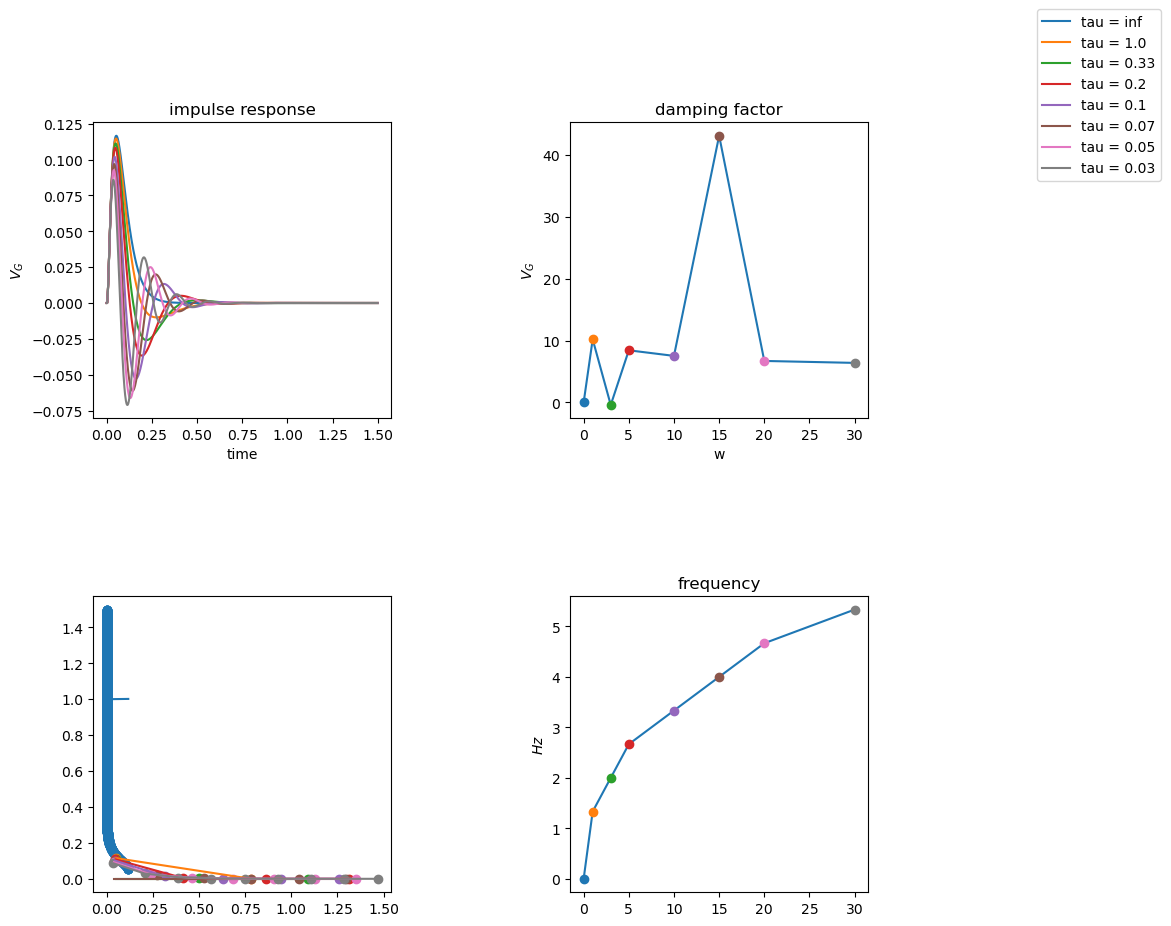

In [42]:
fig = plt.figure(figsize = (10,10))


gs = fig.add_gridspec(2,2)
ax0 = fig.add_subplot(gs[0,0])
ax00 = fig.add_subplot(gs[1,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,1])


fig.subplots_adjust(hspace = 0.6,
                    wspace = 0.6)



damp_w = []
freq_w = []
signal_w = []
peaks_x = []
peaks_y = []
popts = []
for i,val in enumerate(vals_w): 

    # load output 
    with open(f'{fp}/{param}/{param}_{val}/out_impulse', 'rb') as handle:
        out_impulse = pickle.load(handle)  

    with open(f'{fp}/params', 'rb') as handle:
        params = pickle.load(handle)    
 
    time_impulse = np.arange(0,len(out_impulse['VG']))*params['dt']  
    resp = out_impulse['VG']#/np.max(out_impulse['VG'])
    line = ax0.plot(time_impulse, resp, label = f'tau = {np.round(1/val,2)}')

    peaks,heights = find_peaks(resp, height = 0)

    # damp_tau.append(calc_damping(tauA,tauB))
    if len(peaks) > 1:
        x = time_impulse[peaks]
        peaks_y.append(heights['peak_heights'])
        peaks_x.append(x)
    else:
        x =out_impulse['VG'][out_impulse['VG'].argmax():]
        peaks_x.append(out_impulse['VG'][out_impulse['VG'].argmax():])
        peaks_y.append(time_impulse[out_impulse['VG'].argmax():])

        
    popt,_ = curve_fit(expfun,peaks_x[-1],peaks_y[-1],p0 = (5,0.03))
    popts.append(1/popt[0])
    frequency = main_frequency( out_impulse['VG'], 1/params['dt'])


    ax00.plot(x,expfun(x,*popt))
    ax00.scatter(x,peaks_y[-1])
    frequency_tau = main_frequency( out_impulse['VG'], 1/params['dt'])
    signal_w.append(out_impulse['VG'])
    freq_w.append(frequency)
    # ax1.scatter(val,damp_tau[-1]/2-3, zorder = 10)
    ax1.scatter(val,1/popt[0], zorder = 10)
    ax2.scatter(val,freq_w[-1], zorder = 10)


# ax1.plot(vals_w,np.array(damp_tau))
# ax1.plot(vals_tau,np.array(damp_tau)/2-3)
ax1.plot(vals_w,np.array(popts))
ax2.plot(vals_w,freq_w)
  
ax0.set_xlabel('time')
ax0.set_ylabel('$V_{G}$')
ax0.set_title('impulse response')

ax1.set_xlabel('w')
ax1.set_ylabel('$V_{G}$')
ax1.set_title('damping factor')

ax2.set_ylabel('$Hz$')
ax2.set_title('frequency')


fig.legend(loc = 'upper right', bbox_to_anchor = (1.2,1.))

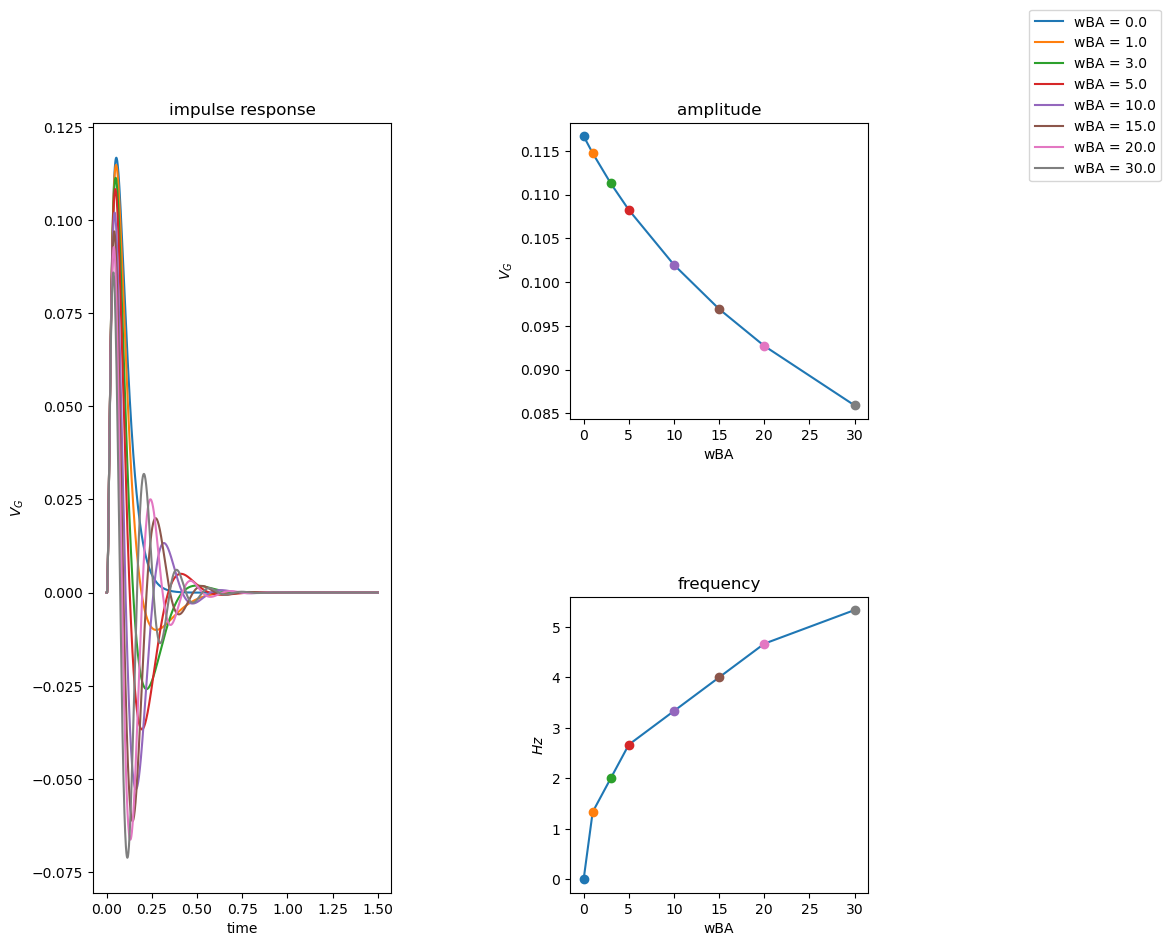

In [43]:
fig = plt.figure(figsize = (10,10))

gs = fig.add_gridspec(2,2)
ax0 = fig.add_subplot(gs[:,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,1])

fig.subplots_adjust(hspace = 0.6,
                    wspace = 0.6)



amp_w = []
freq_w = []
signal_w = []
for i,val in enumerate(vals_w): 

    # load output 
    with open(f'{fp}/{param}/{param}_{val}/out_impulse', 'rb') as handle:
        out_impulse = pickle.load(handle)  

    with open(f'{fp}/params', 'rb') as handle:
        params = pickle.load(handle)    
 
    time_impulse = np.arange(0,len(out_impulse['VG']))*params['dt']  

    ax0.plot(time_impulse, out_impulse['VG'], label = f'wBA = {val}')

    amp_w.append(np.max(out_impulse['VG']))

    frequency = main_frequency( out_impulse['VG'], 1/params['dt'])
    freq_w.append(frequency)
    signal_w.append(out_impulse['VG'])

    ax1.scatter(val,amp_w[-1], zorder = 10)
    ax2.scatter(val,freq_w[-1], zorder = 10)


ax1.plot(vals_w,amp_w)
ax2.plot(vals_w,freq_w)
  
ax0.set_xlabel('time')
ax0.set_ylabel('$V_{G}$')
ax0.set_title('impulse response')



ax1.set_xlabel('wBA')
ax1.set_ylabel('$V_{G}$')
ax1.set_title('amplitude')


ax2.set_xlabel('wBA')
ax2.set_ylabel('$Hz$')
ax2.set_title('frequency')

fig.legend(loc = 'upper right', bbox_to_anchor = (1.2,1.))

# plot for multiple values of absolute time constants (keep distance between them same) SUPPLEMENTARY

-> the bigger the time constants the more the response becomes polyphasic 

-> the frequency stays constant 

-> the more the step reponse becomes transient ond oscillating

In [44]:
param = 'tauB'
vals = np.arange(0.03,0.14,0.01)
vals= np.round(vals,4)


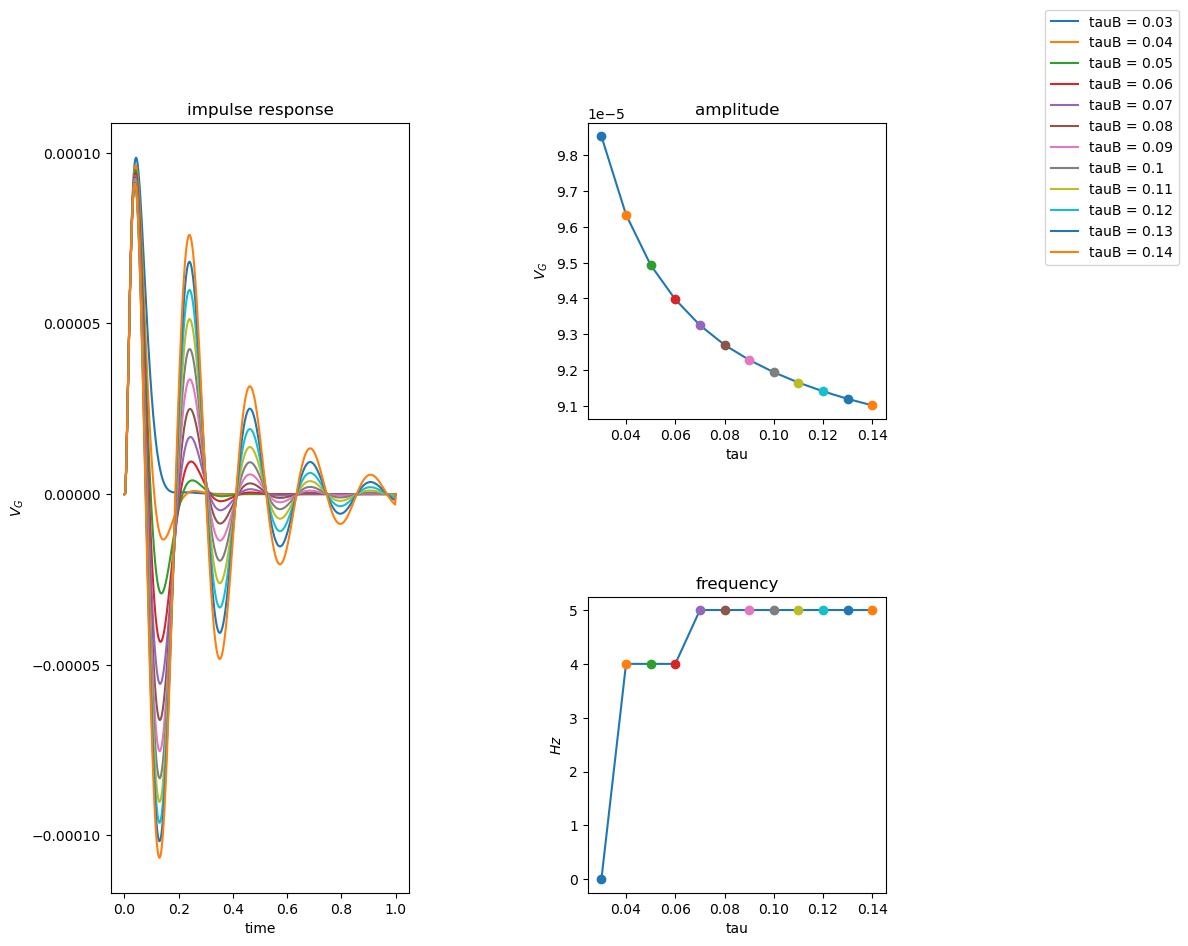

In [45]:
fig = plt.figure(figsize = (10,10))

gs = fig.add_gridspec(2,2)
ax0 = fig.add_subplot(gs[:,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,1])

fig.subplots_adjust(hspace = 0.6,
                    wspace = 0.6)



amp = []
freq = []
for i,val in enumerate(vals): 

    # load output 
    with open(f'{fp}/{param}/{param}_{val}/out_impulse', 'rb') as handle:
        out_impulse = pickle.load(handle)  

    with open(f'{fp}/params', 'rb') as handle:
        params = pickle.load(handle)    
 
    time_impulse = np.arange(0,len(out_impulse['VG']))*params['dt']  

    ax0.plot(time_impulse, out_impulse['VG'], label = f'tauB = {val}')

    amp.append(np.max(out_impulse['VG']))

    frequency = main_frequency( out_impulse['VG'], 1/params['dt'])
    freq.append(frequency)
    ax1.scatter(val,amp[-1], zorder = 10)
    ax2.scatter(val,freq[-1], zorder = 10)


ax1.plot(vals,amp)
ax2.plot(vals,freq)
  
ax0.set_xlabel('time')
ax0.set_ylabel('$V_{G}$')
ax0.set_title('impulse response')



ax1.set_xlabel('tau')
ax1.set_ylabel('$V_{G}$')
ax1.set_title('amplitude')


ax2.set_xlabel('tau')
ax2.set_ylabel('$Hz$')
ax2.set_title('frequency')

fig.legend(loc = 'upper right', bbox_to_anchor = (1.2,1.))

# same for relative distance 

 -> only changes the amplitude 

In [46]:
param = 'tauA'
vals_tau = np.linspace(1.,10,10)
vals

tauB = 0.08



In [47]:
# x = np.array([0.04 , 0.242, 0.463, 0.682, 0.902])
# y= np.array([1.00000000e+00, 1.62930343e-01, 1.27865157e-02, 1.02556470e-03,
#         8.26008768e-05])
# plt.scatter(x,y)
# plt.plot(x,expfun(x,1/9,0.04))


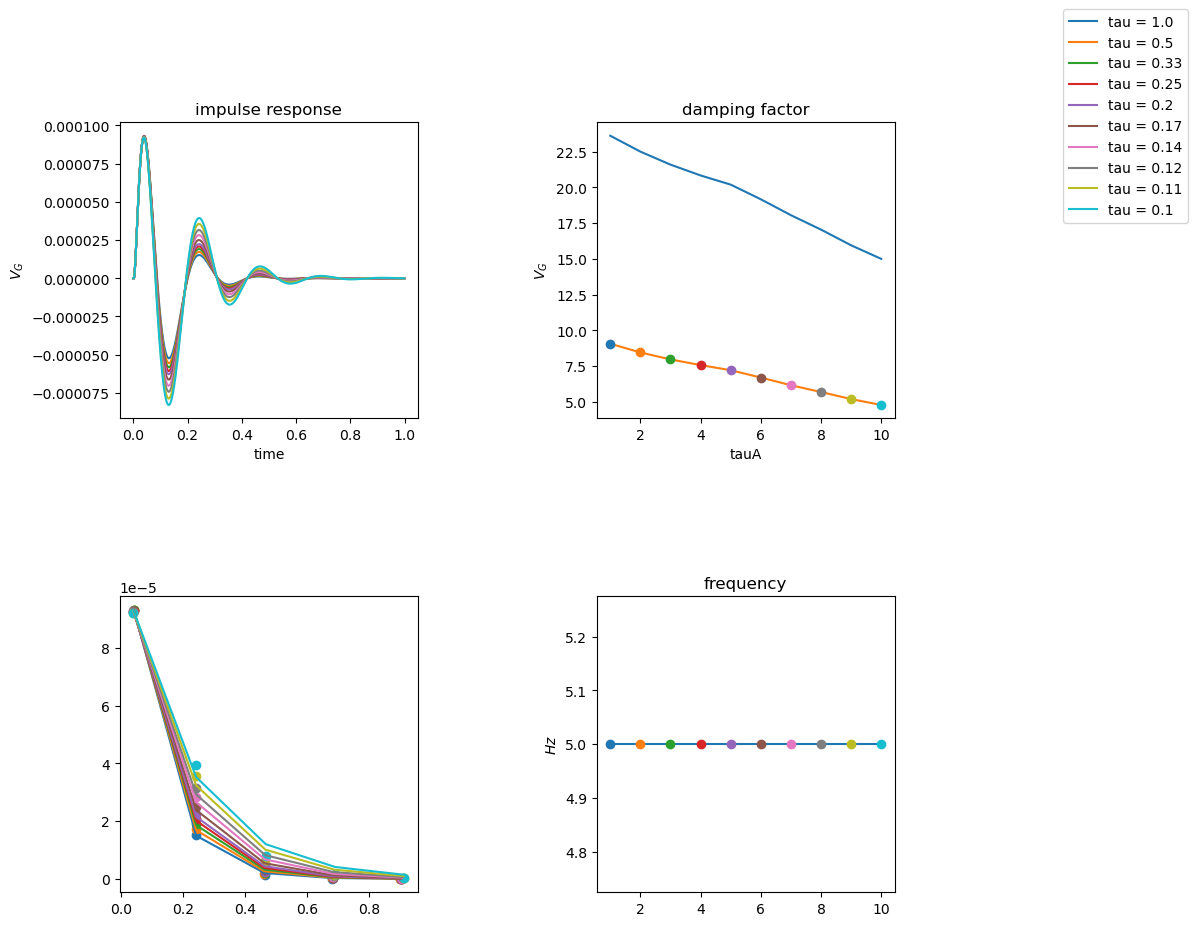

In [48]:
fig = plt.figure(figsize = (10,10))


gs = fig.add_gridspec(2,2)
ax0 = fig.add_subplot(gs[0,0])
ax00 = fig.add_subplot(gs[1,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,1])


fig.subplots_adjust(hspace = 0.6,
                    wspace = 0.6)



damp_tau = []
freq_tau = []
signal_tau = []
peaks_x = []
peaks_y = []
popts = []
for i,val in enumerate(vals_tau): 
    x = val
    tauB = 0.08
    tauA =  np.round(1/(-x+1/tauB),2)
    # load output 
    with open(f'{fp}/{param}/{param}_{tauA}/out_impulse', 'rb') as handle:
        out_impulse = pickle.load(handle)  

    with open(f'{fp}/params', 'rb') as handle:
        params = pickle.load(handle)    
 
    time_impulse = np.arange(0,len(out_impulse['VG']))*params['dt']  
    resp = out_impulse['VG']#/np.max(out_impulse['VG'])
    line = ax0.plot(time_impulse, resp, label = f'tau = {np.round(1/val,2)}')

    peaks,heights = find_peaks(resp, height = 0)

    damp_tau.append(calc_damping(tauA,tauB))
    x = time_impulse[peaks]
    peaks_x.append(x)
    peaks_y.append(heights['peak_heights'])

    popt,_ = curve_fit(expfun,x,heights['peak_heights'],p0 = (5,0.03))
    popts.append(1/popt[0])


    ax00.plot(x,expfun(x,*popt))
    ax00.scatter(x,heights['peak_heights'])
    frequency_tau = main_frequency( out_impulse['VG'], 1/params['dt'])
    signal_tau.append(out_impulse['VG'])
    freq_tau.append(frequency)
    # ax1.scatter(val,damp_tau[-1]/2-3, zorder = 10)
    ax1.scatter(val,1/popt[0], zorder = 10)
    ax2.scatter(val,freq_tau[-1], zorder = 10)


ax1.plot(vals_tau,np.array(damp_tau))
# ax1.plot(vals_tau,np.array(damp_tau)/2-3)
ax1.plot(vals_tau,np.array(popts))
ax2.plot(vals_tau,freq_tau)
  
ax0.set_xlabel('time')
ax0.set_ylabel('$V_{G}$')
ax0.set_title('impulse response')


ax1.set_xlabel('tauA')
ax1.set_ylabel('$V_{G}$')
ax1.set_title('damping factor')

ax2.set_ylabel('$Hz$')
ax2.set_title('frequency')


fig.legend(loc = 'upper right', bbox_to_anchor = (1.2,1.))

In [49]:
# TODO figure with envelope to quantify damping ??
# TODO heatmap for implulse frequency and amplitude

In [50]:
params['wAB']

10.0

ValueError: x and y must have same first dimension, but have shapes (1000,) and (1500,)

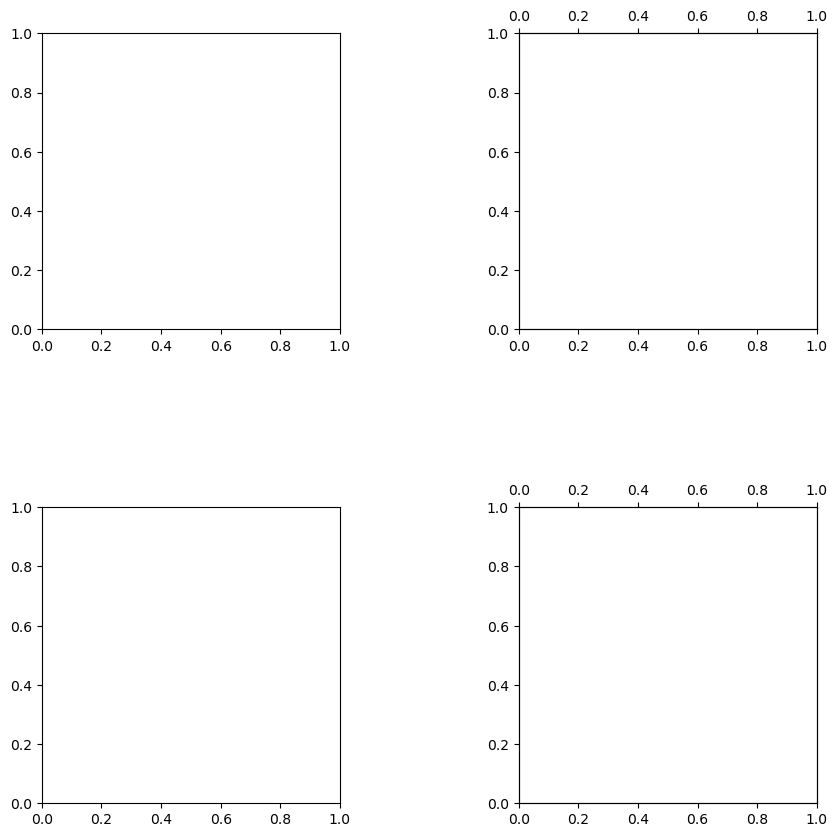

In [51]:
fig = plt.figure(figsize = (10,10))


gs = fig.add_gridspec(2,2)

ax0w = fig.add_subplot(gs[0,0])
ax0t = fig.add_subplot(gs[1,0])
ax1 = fig.add_subplot(gs[0,1])

ax1t = ax1.twiny()
ax2 = fig.add_subplot(gs[1,1])
ax2t = ax2.twiny()

fig.subplots_adjust(hspace = 0.6,
                    wspace = 0.6)



for i,val in enumerate(vals_w): 

    x = val
 
    ax0w.plot(time_impulse, signal_w[i], label = f'w = {val*10.}', color = 'g', alpha = i*0.1+0.1)  # *10  because w = wB*wAB

    ax1.scatter(val,amp_w[i], zorder = 10, color = 'g', alpha = i*0.1+0.1)
    ax2.scatter(val,freq_w[i], zorder = 10, color = 'g', alpha = i*0.1+0.1)


for i,val in enumerate(vals_tau): 

    x = val
 
    ax0t.plot(time_impulse, signal_tau[i], label = f'tau = {np.round(1/val,2)}', color = 'm', alpha = i*0.1+0.1)

    ax1t.scatter(val,amp_tau[i], zorder = 10, color = 'm', alpha = i*0.1+0.1)
    ax2t.scatter(val,freq_tau[i], zorder = 10, color = 'm', alpha = i*0.1+0.1)


ax1t.plot(vals_tau,amp_tau, color = 'm')
ax2t.plot(vals_tau,freq_tau, color = 'm')

ax1.plot(vals_w,amp_w, color = 'g')
ax2.plot(vals_w,freq_w, color = 'g')
  
  
ax0w.set_xlabel('time')
ax0w.set_ylabel('$V_{G}$')
ax0w.set_title('impulse response')

ax0t.set_xlabel('time')
ax0t.set_ylabel('$V_{G}$')
ax0t.set_title('impulse response')



ax1.set_xlabel('w',color = 'g')
ax1t.set_xlabel('tau',color = 'm')
ax1.set_ylabel('$V_{G}$')
ax1.set_title('amplitude')


ax2.set_xlabel('w',color = 'g')
ax2t.set_xlabel('tau',color = 'm')
ax2.set_ylabel('$Hz$')
ax2.set_title('frequency')

ax0t.legend(loc = 'upper right')
ax0w.legend(loc = 'upper right')